# Imports 

In [1]:
import patch_path
import torchcde
import torch

from mt_code.datasets import get_data, load_dataset, PersonData, P300Dataset
from mt_code.models import NeuralCde, OdeLstm, LmuLstm, EegNet

from mt_code.runners import Learner as IrregularSequenceLearner

In [2]:
import os
import torch
#from torch import nn
#import torch.utils.data as data
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

/home/alina/conda/anaconda3/envs/neiry/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
import tensorboard
from pytorch_lightning import loggers as pl_loggers


# Experiments

## P300

###### EEGNET

In [3]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_f1',
    mode = 'max',
    dirpath='logs/models/demons/EEGNET/',
    save_top_k = 3,
)

In [4]:
trainloader, testloader, in_features, num_classes, return_sequences, class_balance = load_dataset(
    'p300_T', timestamps=False, coeffs=False, batch_size=1024,  data_dir = '../data/demons/nery_demons_dataset')

train_x.shape:  torch.Size([45232, 40, 8])
train_y.shape:  torch.Size([45232])
Total number of train sequences: 45232
Total number of test  sequences: 11308
torch.Size([45232, 40, 1]) torch.Size([45232, 8, 40])


In [5]:
eegnet = EegNet(
    input_size =(8, 40),
    rate = 50,
    F1 = 2,
    D = 4,
)
learn = IrregularSequenceLearner(eegnet, lr=0.05, timestamps=False, class_weights = 1/class_balance)


/home/alina/conda/anaconda3/envs/neiry/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:


trainer = pl.Trainer(
    max_epochs=10,
    progress_bar_refresh_rate=1,
    gradient_clip_val=1,
    callbacks=[checkpoint_callback]
    
)
trainer.fit(learn, trainloader, val_dataloaders = testloader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type     | Params
--------------------------------------
0 | model    | EegNet   | 360   
1 | accuracy | Accuracy | 0     
2 | f1       | F1       | 0     
--------------------------------------
360       Trainable params
0         Non-trainable params
360       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  79%|███████▉  | 45/57 [00:02<00:00, 21.95it/s, loss=0.501, v_num=102, val_loss=0.694, val_f1=0.714, val_acc=0.802, train_acc=0.798, train_f1=0.708, train_loss=0.505]
Validating: 0it [00:00, ?it/s]
Epoch 1:  79%|███████▉  | 45/57 [00:02<00:00, 21.48it/s, loss=0.501, v_num=102, val_loss=0.883, val_f1=0.712, val_acc=0.801, train_acc=0.798, train_f1=0.708, train_loss=0.505]
Validating: 0it [00:00, ?it/s]
Epoch 2:  79%|███████▉  | 45/57 [00:03<00:00, 14.21it/s, loss=0.497, v_num=102, val_loss=0.928, val_f1=0.712, val_acc=0.801, train_acc=0.813, train_f1=0.730, train_loss=0.482]
Validating: 0it [00:00, ?it/s]
Epoch 3:  79%|███████▉  | 45/57 [00:02<00:00, 17.62it/s, loss=0.502, v_num=102, val_loss=0.923, val_f1=0.712, val_acc=0.801, train_acc=0.794, train_f1=0.703, train_loss=0.509]
Validating: 0it [00:00, ?it/s]
Epoch 4:  79%|███████▉  | 45/57 [00:02<00:00, 18.41it/s, loss=0.496, v_num=102, val_loss=0.907, val_f1=0.712, val_acc=0.801, train_acc=0.805, train_f1=0.718, train_loss=0.4

1

In [9]:
best_path = checkpoint_callback.best_model_path
checkpoint = torch.load(best_path)
states = {}
for k_new, k_old in zip(eegnet.state_dict().keys(), checkpoint['state_dict'].keys()):
    states[k_new] = checkpoint['state_dict'].get(k_old)
eegnet.load_state_dict(state_dict = states)
    

<All keys matched successfully>

In [10]:
learn = IrregularSequenceLearner(eegnet, lr=0.01, timestamps=False,  class_weights = 1/class_balance)

results = trainer.test(learn, testloader)
base_path = "results/{}".format("person")
os.makedirs(base_path, exist_ok=True)
with open("{}/pt_ode_lstm_{}.csv".format(base_path, 128), "a") as f:
    f.write("{:06f}\n".format(results[0]["val_acc"]))

Testing: 100%|██████████| 12/12 [00:00<00:00, 37.62it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'val_acc': 0.8007605075836182,
 'val_f1': 0.7121887803077698,
 'val_loss': 0.8833798766136169}
--------------------------------------------------------------------------------


### CDE

In [11]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_f1',
    mode = 'max',
    dirpath='logs/models/demons/cde/',
    save_top_k = 3,
)

/home/alina/conda/anaconda3/envs/neiry/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: Checkpoint directory logs/models/demons/cde/ exists and is not empty.
  warnings.warn(*args, **kwargs)


In [4]:
import numpy as np
import torch.utils.data as data


In [9]:
def load_dataset(
    ds="activity",
    timestamps=True,
    coeffs=False,
    irregular = True,
    batch_size=128,
    data_dir="../data/person",
):
    if ds == "activity":
        dataset = PersonData(data_dir=data_dir)
        train_ts = torch.Tensor(dataset.train_t)
        test_ts = torch.Tensor(dataset.test_t)
    elif ds == "p300":
        dataset = P300Dataset(data_dir=data_dir)
        dataset.get_data_for_experiments(True)
        train_ts = torch.Tensor(dataset.train_t)[:, :, None]
        test_ts = torch.Tensor(dataset.test_t)[:, :, None]
    elif ds == "p300_T":
        dataset = P300Dataset(data_dir=data_dir)
        dataset.get_data_for_experiments(True)
        xs = dataset.train_x.shape
        dataset.train_x = dataset.train_x.reshape(xs[0], xs[2], xs[1])
        xs = dataset.test_x.shape
        dataset.test_x = dataset.test_x.reshape(xs[0], xs[2], xs[1])
        train_ts = torch.Tensor(dataset.train_t)[:, :, None]
        test_ts = torch.Tensor(dataset.test_t)[:, :, None]
    else:
        raise ValueError(f'No such dataset: {ds}, try "activity"')


    train_x = torch.Tensor(dataset.train_x)
    test_x = torch.Tensor(dataset.test_x)

    train_y = torch.LongTensor(dataset.train_y)
    test_y = torch.LongTensor(dataset.test_y)
    print('classes:', train_y[:50])
    if irregular:
        print(train_ts.shape, train_ts.size(1))
        print(test_ts.shape, test_ts.size(1))
        
        for ts in range(len(train_ts)):
            irr_idc_train = np.random.choice(np.arange(0, train_ts.size(1)), size = int(0.8*train_ts.size(1)), replace = False)
            irr_idc_train.sort()
            print(irr_idc_train)
            train_ts[ts, :, :] = train_ts[ts, irr_idc_train,:]
            train_x[ts, :, :] = train_x[ts, irr_idc_train, :]
            if train_y.dim()>1:
                train_y[ts, :] = train_ts[ts, irr_idc_train]
        
        for ts in range(len(test_ts)):
        
            irr_idc_test = np.random.choice(np.arange(0, test_ts.size(1)), size = int(0.8*test_ts.size(1)), replace = False)
            irr_idc_test.sort()
        
            test_ts = test_ts[:,irr_idc_test,:]
            test_x = test_x[:, irr_idc_test, :]
            if train_y.dim()>1:
                test_y[ts, :] = train_ts[ts, irr_idc_test] 
                
        print(train_ts.shape, train_ts.size(1))
        print(test_ts.shape, test_ts.size(1))
               
        
    
    print(train_ts.size(), train_x.size())

    if coeffs:
        train_x = torch.cat([train_ts, train_x], dim=2)
        train_x = torchcde.natural_cubic_coeffs(
            torch.Tensor(dataset.train_x)
        )  # , dtype=torch.float32))
        test_x = torch.cat([test_ts, test_x], dim=2)
        test_x = torchcde.natural_cubic_coeffs(
            torch.Tensor(dataset.test_x)
        )  # , dtype=torch.float32))

    if timestamps:
        train = data.TensorDataset(train_x, train_ts, train_y)
        test = data.TensorDataset(test_x, test_ts, test_y)
    else:
        train = data.TensorDataset(train_x, train_y)
        test = data.TensorDataset(test_x, test_y)
    return_sequences = True

    counts = test_y.unique(return_counts=True)[1].to(torch.float)
    class_balance = counts / counts.min()

    trainloader = data.DataLoader(
        train, batch_size=batch_size, shuffle=True, num_workers=4
    )
    testloader = data.DataLoader(
        test, batch_size=batch_size, shuffle=False, num_workers=4
    )
    in_features = train_x.size(-1)
    num_classes = int(torch.max(train_y).item() + 1)
    return (
        trainloader,
        testloader,
        in_features,
        num_classes,
        return_sequences,
        class_balance,
    )


In [12]:
trainloader, testloader, in_features, num_classes, return_sequences, class_balance = load_dataset(
    'p300', timestamps=False, coeffs=True, irregular = True, batch_size=1024,  data_dir = '../data/demons/nery_demons_dataset')

train_x.shape:  torch.Size([39578, 40, 8])
train_y.shape:  torch.Size([39578])
Total number of train sequences: 39578
Total number of test  sequences: 16962
torch.Size([39578, 40, 1]) 40
torch.Size([16962, 40, 1]) 40
[ 0  1  2  3  4  6  7  8  9 10 12 13 15 16 17 18 19 21 22 23 25 28 29 31
 32 33 34 35 36 37 38 39]
torch.Size([39578, 32, 1]) 32
torch.Size([16962, 32, 1]) 32
torch.Size([39578, 32, 1]) torch.Size([39578, 32, 8])


In [ ]:
trainloader, testloader, in_features, num_classes, return_sequences, class_balance = load_dataset(
    'p300', timestamps=False, coeffs=True, irregular = False, batch_size=1024,  data_dir = '../data/demons/nery_demons_dataset')

In [26]:
cde = NeuralCde(
    8,#original num of features
    8,
    num_classes,

    return_sequences=False,
    #memory = True,
    #gated=True
    #solver_type='fixed_rk4',
)
learn = IrregularSequenceLearner(cde, lr=0.05, timestamps=False, class_weights = 1/class_balance)


In [27]:
tb_logger = pl_loggers.TensorBoardLogger('logs_pl/')

In [28]:


trainer = pl.Trainer(
    max_epochs=5,
    progress_bar_refresh_rate=1,
    gradient_clip_val=0,
    callbacks=[checkpoint_callback],
    logger = tb_logger,
    log_every_n_steps=1,
    val_check_interval=0.02,
    
    
)
trainer.fit(learn, trainloader, val_dataloaders = testloader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type      | Params
---------------------------------------
0 | model    | NeuralCde | 9.5 K 
1 | accuracy | Accuracy  | 0     
2 | f1       | F1        | 0     
---------------------------------------
9.5 K     Trainable params
0         Non-trainable params
9.5 K     Total params
0.038     Total estimated model params size (MB)


Epoch 0:   0%|          | 1/702 [00:11<2:18:29, 11.85s/it, loss=1.12, v_num=5, val_loss=1.060, val_f1=0.556, val_acc=0.506]
Validating: 0it [00:00, ?it/s]
Epoch 0:   3%|▎         | 20/702 [01:07<38:26,  3.38s/it, loss=2.32, v_num=5, val_loss=2.870, val_f1=0.429, val_acc=0.392, train_acc=0.488, train_f1=0.534, train_loss=1.120]
Validating: 0it [00:00, ?it/s]
Epoch 0:   6%|▌         | 39/702 [02:17<39:02,  3.53s/it, loss=1.89, v_num=5, val_loss=2.070, val_f1=0.697, val_acc=0.712, train_acc=0.410, train_f1=0.447, train_loss=3.530]
Validating: 0it [00:00, ?it/s]
Epoch 0:   8%|▊         | 59/702 [03:30<38:13,  3.57s/it, loss=1.67, v_num=5, val_loss=1.930, val_f1=0.707, val_acc=0.737, train_acc=0.729, train_f1=0.723, train_loss=1.030]
Validating: 0it [00:00, ?it/s]
Epoch 0:  11%|█         | 77/702 [04:41<38:04,  3.65s/it, loss=1.51, v_num=5, val_loss=1.700, val_f1=0.704, val_acc=0.728, train_acc=0.734, train_f1=0.705, train_loss=0.996]
Validating: 0it [00:00, ?it/s]
Epoch 0:  14%|█▎        |

Epoch 0:  19%|█▉        | 134/702 [09:24<39:52,  4.21s/it, loss=1.37, v_num=5, val_loss=1.590, val_f1=0.614, val_acc=0.573, train_acc=0.562, train_f1=0.605, train_loss=1.270]
Validating: 0it [00:00, ?it/s]
Epoch 0:  22%|██▏       | 153/702 [11:16<40:28,  4.42s/it, loss=1.34, v_num=5, val_loss=1.410, val_f1=0.642, val_acc=0.612, train_acc=0.604, train_f1=0.641, train_loss=1.120]
Validating: 0it [00:00, ?it/s]
Epoch 0:  25%|██▍       | 172/702 [12:46<39:23,  4.46s/it, loss=1.29, v_num=5, val_loss=1.370, val_f1=0.696, val_acc=0.707, train_acc=0.590, train_f1=0.615, train_loss=1.060]
Validating: 0it [00:00, ?it/s]
Epoch 0:  27%|██▋       | 191/702 [14:19<38:18,  4.50s/it, loss=1.24, v_num=5, val_loss=1.460, val_f1=0.712, val_acc=0.756, train_acc=0.697, train_f1=0.683, train_loss=0.832]
Validating: 0it [00:00, ?it/s]
Epoch 0:  30%|██▉       | 210/702 [16:01<37:33,  4.58s/it, loss=1.2, v_num=5, val_loss=1.520, val_f1=0.715, val_acc=0.764, train_acc=0.748, train_f1=0.707, train_loss=0.726] 
V

Epoch 0:  35%|███▌      | 248/702 [19:49<36:16,  4.79s/it, loss=1.13, v_num=5, val_loss=1.450, val_f1=0.714, val_acc=0.755, train_acc=0.770, train_f1=0.714, train_loss=0.707]
Validating: 0it [00:00, ?it/s]
Epoch 0:  38%|███▊      | 267/702 [21:52<35:38,  4.92s/it, loss=1.11, v_num=5, val_loss=1.300, val_f1=0.701, val_acc=0.717, train_acc=0.752, train_f1=0.716, train_loss=0.739]
Validating: 0it [00:00, ?it/s]
Epoch 0:  41%|████      | 286/702 [23:46<34:34,  4.99s/it, loss=1.08, v_num=5, val_loss=1.190, val_f1=0.687, val_acc=0.689, train_acc=0.704, train_f1=0.691, train_loss=0.760]
Validating: 0it [00:00, ?it/s]
Epoch 0:  43%|████▎     | 305/702 [26:00<33:51,  5.12s/it, loss=1.05, v_num=5, val_loss=1.080, val_f1=0.698, val_acc=0.708, train_acc=0.702, train_f1=0.704, train_loss=0.688]
Validating: 0it [00:00, ?it/s]
Epoch 0:  46%|████▌     | 324/702 [27:52<32:30,  5.16s/it, loss=1.03, v_num=5, val_loss=1.080, val_f1=0.717, val_acc=0.766, train_acc=0.715, train_f1=0.701, train_loss=0.655]
V

Epoch 0:  49%|████▉     | 343/702 [30:17<31:41,  5.30s/it, loss=1.01, v_num=5, val_loss=1.160, val_f1=0.718, val_acc=0.770, train_acc=0.757, train_f1=0.693, train_loss=0.617]
Validating: 0it [00:00, ?it/s]
Epoch 0:  52%|█████▏    | 362/702 [32:34<30:35,  5.40s/it, loss=0.983, v_num=5, val_loss=1.150, val_f1=0.716, val_acc=0.763, train_acc=0.772, train_f1=0.730, train_loss=0.561]
Validating: 0it [00:00, ?it/s]
Epoch 0:  54%|█████▍    | 381/702 [34:58<29:27,  5.51s/it, loss=0.959, v_num=5, val_loss=1.130, val_f1=0.710, val_acc=0.744, train_acc=0.796, train_f1=0.755, train_loss=0.558]
Validating: 0it [00:00, ?it/s]
Epoch 0:  57%|█████▋    | 400/702 [37:32<28:20,  5.63s/it, loss=0.818, v_num=5, val_loss=1.070, val_f1=0.704, val_acc=0.724, train_acc=0.737, train_f1=0.700, train_loss=0.634]
Validating: 0it [00:00, ?it/s]
Epoch 0:  60%|█████▉    | 419/702 [40:36<27:25,  5.81s/it, loss=0.799, v_num=5, val_loss=1.010, val_f1=0.700, val_acc=0.714, train_acc=0.691, train_f1=0.668, train_loss=0.70

Epoch 0:  65%|██████▌   | 457/702 [45:28<24:22,  5.97s/it, loss=0.768, v_num=5, val_loss=0.960, val_f1=0.713, val_acc=0.749, train_acc=0.731, train_f1=0.697, train_loss=0.615]
Validating: 0it [00:00, ?it/s]
Epoch 0:  68%|██████▊   | 476/702 [47:56<22:45,  6.04s/it, loss=0.742, v_num=5, val_loss=0.974, val_f1=0.716, val_acc=0.769, train_acc=0.740, train_f1=0.708, train_loss=0.600]
Validating: 0it [00:00, ?it/s]
Epoch 0:  71%|███████   | 495/702 [50:15<21:01,  6.09s/it, loss=0.707, v_num=5, val_loss=1.020, val_f1=0.719, val_acc=0.787, train_acc=0.782, train_f1=0.729, train_loss=0.535]
Validating: 0it [00:00, ?it/s]
Epoch 0:  73%|███████▎  | 514/702 [53:07<19:25,  6.20s/it, loss=0.68, v_num=5, val_loss=1.060, val_f1=0.720, val_acc=0.795, train_acc=0.768, train_f1=0.694, train_loss=0.570] 
Validating: 0it [00:00, ?it/s]
Epoch 0:  76%|███████▌  | 533/702 [55:07<17:28,  6.20s/it, loss=0.657, v_num=5, val_loss=1.080, val_f1=0.719, val_acc=0.797, train_acc=0.788, train_f1=0.713, train_loss=0.5

Epoch 0:  79%|███████▊  | 552/702 [57:51<15:43,  6.29s/it, loss=0.643, v_num=5, val_loss=1.050, val_f1=0.720, val_acc=0.796, train_acc=0.766, train_f1=0.676, train_loss=0.605]
Validating: 0it [00:00, ?it/s]
Epoch 0:  81%|████████▏ | 571/702 [1:00:29<13:52,  6.36s/it, loss=0.634, v_num=5, val_loss=0.995, val_f1=0.720, val_acc=0.790, train_acc=0.781, train_f1=0.696, train_loss=0.557]
Validating: 0it [00:00, ?it/s]
Epoch 0:  84%|████████▍ | 590/702 [1:02:40<11:53,  6.37s/it, loss=0.622, v_num=5, val_loss=0.952, val_f1=0.721, val_acc=0.780, train_acc=0.790, train_f1=0.726, train_loss=0.545]
Validating: 0it [00:00, ?it/s]
Epoch 0:  87%|████████▋ | 609/702 [1:05:05<09:56,  6.41s/it, loss=0.613, v_num=5, val_loss=0.929, val_f1=0.717, val_acc=0.766, train_acc=0.774, train_f1=0.711, train_loss=0.551]
Validating: 0it [00:00, ?it/s]
Epoch 0:  89%|████████▉ | 628/702 [1:07:22<07:56,  6.44s/it, loss=0.604, v_num=5, val_loss=0.937, val_f1=0.718, val_acc=0.770, train_acc=0.777, train_f1=0.729, train_

Epoch 0:  92%|█████████▏| 647/702 [1:09:36<05:55,  6.45s/it, loss=0.594, v_num=5, val_loss=0.965, val_f1=0.721, val_acc=0.788, train_acc=0.765, train_f1=0.707, train_loss=0.564]
Validating: 0it [00:00, ?it/s]
Epoch 0:  95%|█████████▍| 666/702 [1:11:51<03:53,  6.47s/it, loss=0.587, v_num=5, val_loss=1.000, val_f1=0.720, val_acc=0.799, train_acc=0.776, train_f1=0.704, train_loss=0.551]
Validating: 0it [00:00, ?it/s]
Epoch 0:  98%|█████████▊| 685/702 [1:14:26<01:50,  6.52s/it, loss=0.58, v_num=5, val_loss=1.030, val_f1=0.719, val_acc=0.803, train_acc=0.794, train_f1=0.713, train_loss=0.544] 
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 702/702 [1:16:47<00:00,  6.56s/it, loss=0.576, v_num=5, val_loss=1.040, val_f1=0.719, val_acc=0.804, train_acc=0.807, train_f1=0.727, train_loss=0.518]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 702/702 [1:18:56<00:00,  6.75s/it, loss=0.576, v_num=5, val_loss=1.020, val_f1=0.719, val_acc=0.805, train_acc=0.796, train_f1=0.707, trai

Epoch 1:   3%|▎         | 20/702 [06:18<3:34:53, 18.91s/it, loss=0.566, v_num=5, val_loss=0.962, val_f1=0.719, val_acc=0.805, train_acc=0.812, train_f1=0.728, train_loss=0.503]
Validating: 0it [00:00, ?it/s]
Epoch 1:   5%|▌         | 37/702 [08:58<2:41:23, 14.56s/it, loss=0.566, v_num=5, val_loss=0.962, val_f1=0.719, val_acc=0.805, train_acc=0.812, train_f1=0.728, train_loss=0.503]


1

In [34]:
trainer.logged_metrics

{'val_loss': tensor(1.2117),
 'val_f1': tensor(0.5018),
 'val_acc': tensor(0.4531),
 'epoch': tensor(0.),
 'train_acc': tensor(0.5996),
 'train_f1': tensor(0.6237),
 'train_loss': tensor(0.6872)}

In [33]:
help(trainer)

Help on Trainer in module pytorch_lightning.trainer.trainer object:

class Trainer(pytorch_lightning.trainer.properties.TrainerProperties, pytorch_lightning.trainer.callback_hook.TrainerCallbackHookMixin, pytorch_lightning.trainer.model_hooks.TrainerModelHooksMixin, pytorch_lightning.trainer.optimizers.TrainerOptimizersMixin, pytorch_lightning.trainer.logging.TrainerLoggingMixin, pytorch_lightning.trainer.training_tricks.TrainerTrainingTricksMixin, pytorch_lightning.trainer.data_loading.TrainerDataLoadingMixin, pytorch_lightning.trainer.deprecated_api.DeprecatedDistDeviceAttributes, pytorch_lightning.trainer.deprecated_api.DeprecatedTrainerAttributes)
 |  Trainer(logger: Union[pytorch_lightning.loggers.base.LightningLoggerBase, Iterable[pytorch_lightning.loggers.base.LightningLoggerBase], bool] = True, checkpoint_callback: bool = True, callbacks: Union[List[pytorch_lightning.callbacks.base.Callback], pytorch_lightning.callbacks.base.Callback, NoneType] = None, default_root_dir: Union[s

In [35]:
best_path = "./logs/models/demons/cde/epoch=4-step=224.ckpt"
checkpoint = torch.load(best_path)
states = {}
for k_new, k_old in zip(cde.state_dict().keys(), checkpoint['state_dict'].keys()):
    states[k_new] = checkpoint['state_dict'].get(k_old)
cde.load_state_dict(state_dict = states)
    

<All keys matched successfully>

In [10]:
learn = IrregularSequenceLearner(cde, lr=0.01, timestamps=False,  class_weights = 1/class_balance)

results = trainer.test(learn, testloader)
base_path = "results/{}".format("person")
os.makedirs(base_path, exist_ok=True)
with open("{}/pt_ode_lstm_{}.csv".format(base_path, 128), "a") as f:
    f.write("{:06f}\n".format(results[0]["val_acc"]))

Testing: 100%|██████████| 17/17 [01:46<00:00,  6.25s/it]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'val_acc': 0.8053885102272034,
 'val_f1': 0.7188411951065063,
 'val_loss': 0.9428133368492126}
--------------------------------------------------------------------------------


#### Vis

In [24]:
import matplotlib.pyplot as plt

In [25]:
import numpy as np

In [26]:
# matplotlib
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [27]:
ds = P300Dataset('../data/demons/nery_demons_dataset')
ds.get_data_for_experiments()

In [28]:
data = (ds.train_x, ds.train_y)

/home/alina/conda/anaconda3/envs/neiry/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
idc_p300 = np.where(data[1]==1)[0]

In [30]:
n = 100000
x = torch.stack((data[0][idc_p300[301]], data[0][2]))

In [31]:
x.shape

torch.Size([2, 40, 8])

0


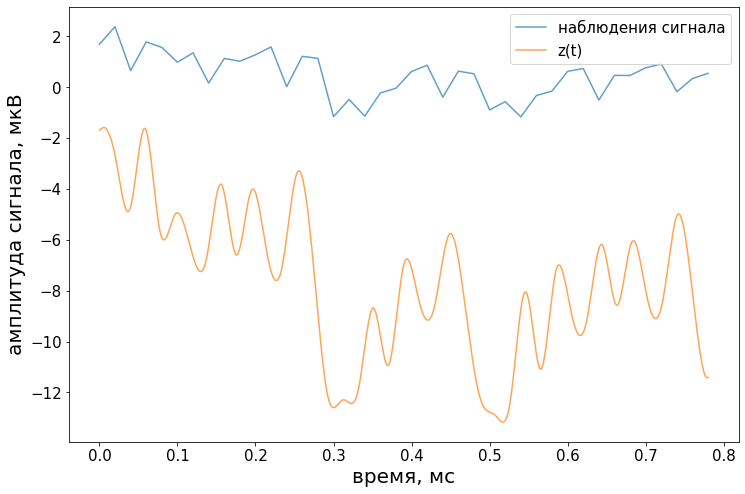

In [36]:
for i in range(1):
    print(i)
    c = torchcde.natural_cubic_coeffs(x)
    X = torchcde.NaturalCubicSpline(c)
    XX = X.evaluate(np.arange(0,x.size(1), x.size(1)/n))
    z0=X.evaluate(0)
    times = torch.arange(0, x.size(1), x.size(1)/n)
    z_t = torchcde.cdeint(X=X, z0=z0, func=cde.func, t=times.to(torch.float32))

    time = ds.train_t[0,:]
    new_time = np.linspace(start=ds.train_t[0,0], stop=ds.train_t[0, -1], num=len(XX[1, :,0]))
    plt.figure(figsize = (12,8))
    plt.plot(time, x[0, :, 0], alpha=0.7, label = 'наблюдения сигнала')
    #plt.plot(new_time, XX[0, :,0], alpha=0.7, label = 'интерполяция сингала')
    plt.plot(new_time, -z_t[0, :, 0].detach().numpy(), alpha=0.7, label = 'z(t)')
    plt.ylabel('амплитуда сигнала, мкВ')
    plt.xlabel('время, мс')
    plt.legend()
    plt.show()

In [16]:
c = torchcde.natural_cubic_coeffs(x)
X = torchcde.NaturalCubicSpline(c)
XX = X.evaluate(np.arange(0,x.size(1), x.size(1)/n))

/home/alina/conda/anaconda3/envs/neiry/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
z0=X.evaluate(0)
times = torch.arange(0, x.size(1), x.size(1)/n)
z_t = torchcde.cdeint(X=X, z0=z0, func=cde.func, t=times.to(torch.float32))

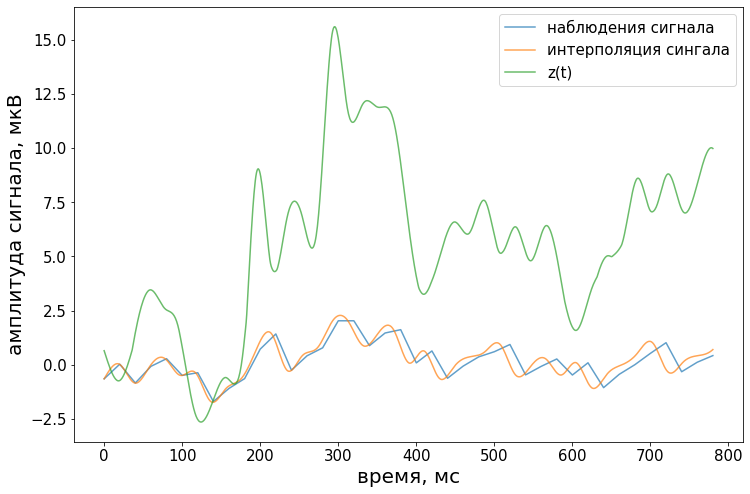

In [18]:
time = ds.train_t[0,:]
new_time = np.linspace(start=ds.train_t[0,0], stop=ds.train_t[0, -1], num=len(XX[1, :,0]))
plt.figure(figsize = (12,8))
plt.plot(time, x[0, :, 0], alpha=0.7, label = 'наблюдения сигнала')
plt.plot(new_time, XX[0, :,0], alpha=0.7, label = 'интерполяция сингала')
plt.plot(new_time, -z_t[0, :, 0].detach().numpy(), alpha=0.7, label = 'z(t)')
plt.ylabel('амплитуда сигнала, мкВ')
plt.xlabel('время, мс')
plt.legend()
plt.show()

/home/alina/conda/anaconda3/envs/neiry/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


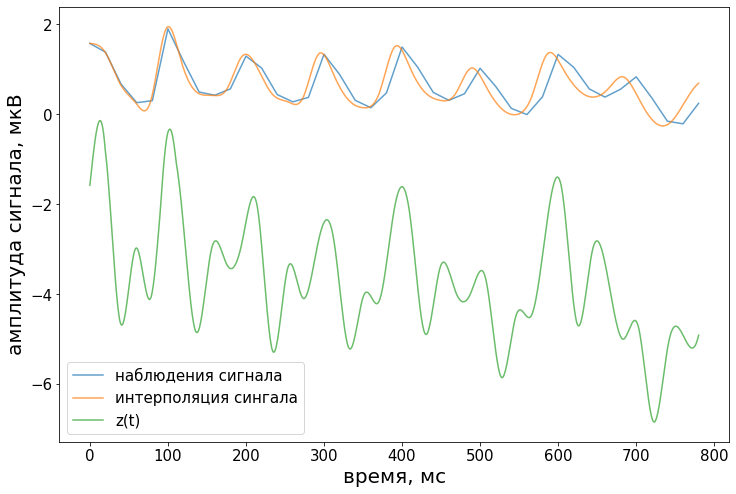

In [19]:
time = ds.train_t[0,:]
new_time = np.linspace(start=ds.train_t[0,0], stop=ds.train_t[0, -1], num=len(XX[1, :,0]))
plt.figure(figsize = (12,8))
plt.plot(time, x[1, :, 0], alpha=0.7, label = 'наблюдения сигнала')
plt.plot(new_time, XX[1, :,0], alpha=0.7, label = 'интерполяция сингала')
plt.plot(new_time, -z_t[1, :, 0].detach().numpy(), alpha=0.7, label = 'z(t)')
plt.ylabel('амплитуда сигнала, мкВ')
plt.xlabel('время, мс')
plt.legend()
plt.show()

### ODELSTM

In [35]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_f1',
    mode = 'max',
    dirpath='logs/models/demons/odelstm/',
    save_top_k = 3,
)

/home/alina/conda/anaconda3/envs/neiry/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: Checkpoint directory logs/models/demons/odelstm/ exists and is not empty.
  warnings.warn(*args, **kwargs)


In [36]:
trainloader, testloader, in_features, num_classes, return_sequences, class_balance = load_dataset(
    'p300', timestamps=True, coeffs=False, batch_size=512,  data_dir = '../data/demons/nery_demons_dataset')

train_x.shape:  torch.Size([39578, 40, 8])
train_y.shape:  torch.Size([39578])
Total number of train sequences: 39578
Total number of test  sequences: 16962
torch.Size([39578, 40, 1]) 40
torch.Size([16962, 40, 1]) 40
[ 0  1  2  3  4  5  7  9 11 13 14 15 16 17 18 19 20 21 22 23 24 25 26 29
 30 33 34 35 36 37 38 39]
torch.Size([39578, 32, 1]) 32
torch.Size([16962, 32, 1]) 32
torch.Size([39578, 32, 1]) torch.Size([39578, 32, 8])


In [37]:
olstm = OdeLstm(
    8,#original num of features
    8,
    num_classes,

    return_sequences=False,
    #memory = True,
    #gated=True
    #solver_type='fixed_rk4',
)
learn = IrregularSequenceLearner(olstm, lr=0.05, timestamps=True, class_weights = 1/class_balance)


/home/alina/conda/anaconda3/envs/neiry/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:


trainer = pl.Trainer(
    max_epochs=10,
    progress_bar_refresh_rate=1,
    gradient_clip_val=1,
    callbacks=[checkpoint_callback]
    
)
trainer.fit(learn, trainloader, val_dataloaders = testloader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type     | Params
--------------------------------------
0 | model    | OdeLstm  | 738   
1 | accuracy | Accuracy | 0     
2 | f1       | F1       | 0     
--------------------------------------
738       Trainable params
0         Non-trainable params
738       Total params
0.003     Total estimated model params size (MB)


Epoch 0:   1%|          | 1/112 [01:14<2:17:03, 74.08s/it, loss=0.594, v_num=119, val_loss=0.720, val_f1=0.704, val_acc=0.795]


/home/alina/conda/anaconda3/envs/neiry/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [39]:
trainer.logged_metrics

{'val_loss': tensor(0.7196),
 'val_f1': tensor(0.7041),
 'val_acc': tensor(0.7949),
 'epoch': tensor(0.),
 'train_acc': tensor(0.8066),
 'train_f1': tensor(0.7203),
 'train_loss': tensor(0.5941)}

In [42]:
hidden_state = [
            torch.zeros((2, olstm.hidden_size)),
            torch.zeros((2, olstm.hidden_size)),
        ]
outputs = []
last_output = torch.zeros((2, olstm.out_feature))
for t in range(x.size(1)):
    inputs = x[:, t]
    ts = times[:, t].squeeze()
    hidden_state = olstm.rnn_cell.forward(inputs, hidden_state, ts)
    outputs.append(hidden_state[0])

In [43]:
out = torch.stack(outputs).detach().numpy()

/home/alina/conda/anaconda3/envs/neiry/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


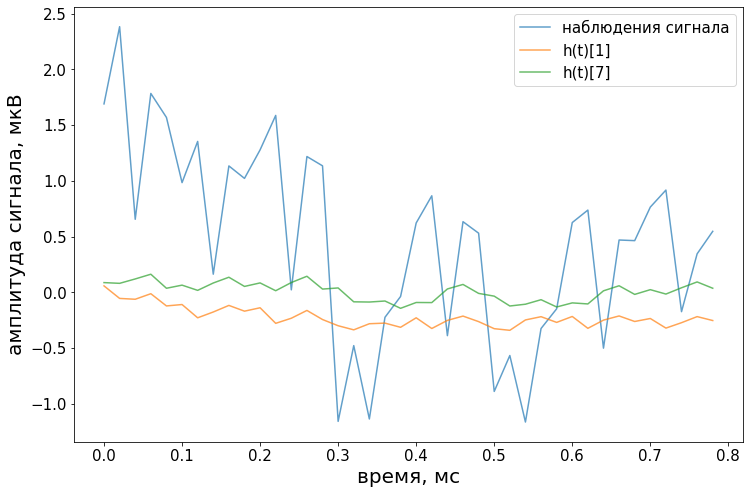

In [50]:
plt.figure(figsize = (12,8))
plt.plot(time, x[0, :, 0], alpha=0.7, label = 'наблюдения сигнала')
plt.plot(time, out[:, 0, 6], alpha=0.7, label = 'h(t)[1]')
plt.plot(time, out[:, 0, -1], alpha=0.7, label = 'h(t)[7]')

plt.ylabel('амплитуда сигнала, мкВ')
plt.xlabel('время, мс')
plt.legend()
plt.show()

In [23]:


results = trainer.test(learn, testloader)
base_path = "results/{}".format("person_lcde")
os.makedirs(base_path, exist_ok=True)
with open("{}/pt_ode_lstm_{}.csv".format(base_path, 128), "a") as f:
    f.write("{:06f}\n".format(results[0]["val_acc"]))

Testing: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'val_acc': 0.7930079102516174,
 'val_f1': 0.7214646339416504,
 'val_loss': 0.6962085962295532}
--------------------------------------------------------------------------------


### LMULSTM

In [6]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_f1',
    mode = 'max',
    dirpath='logs/models/demons/lmulstm/',
    save_top_k = 3,
)

/home/alina/conda/anaconda3/envs/neiry/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: Checkpoint directory logs/models/demons/lmulstm/ exists and is not empty.
  warnings.warn(*args, **kwargs)


In [7]:
trainloader, testloader, in_features, num_classes, return_sequences, class_balance = load_dataset(
    'p300', timestamps=False, coeffs=False, batch_size=1024,  data_dir = '../data/demons/nery_demons_dataset')

train_x.shape:  torch.Size([39578, 40, 8])
train_y.shape:  torch.Size([39578])
Total number of train sequences: 39578
Total number of test  sequences: 16962
torch.Size([39578, 40, 1]) 40
torch.Size([16962, 40, 1]) 40
[ 1  3  5  6  7  8  9 10 11 14 15 16 17 18 19 20 21 22 23 24 25 26 27 29
 30 31 34 35 36 37 38 39]
torch.Size([39578, 32, 1]) 32
torch.Size([16962, 32, 1]) 32
torch.Size([39578, 32, 1]) torch.Size([39578, 32, 8])


In [8]:
lmu = LmuLstm(
    8,#original num of features
    2,
    2,
    num_classes,
    theta = 0.5,
    return_sequences=False,
    #memory = True,
    #gated=True
    #solver_type='fixed_rk4',
)
learn = IrregularSequenceLearner(lmu, lr=0.05, timestamps=False, class_weights = 1/class_balance)


/home/alina/conda/anaconda3/envs/neiry/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
tb_logger = pl_loggers.TensorBoardLogger('logs_pl/')

In [10]:


trainer = pl.Trainer(
    max_epochs=10,
    progress_bar_refresh_rate=1,
    gradient_clip_val=1,
    callbacks=[checkpoint_callback],
    logger = tb_logger
)
trainer.fit(learn, trainloader, val_dataloaders = testloader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type     | Params
--------------------------------------
0 | model    | LmuLstm  | 66    
1 | accuracy | Accuracy | 0     
2 | f1       | F1       | 0     
--------------------------------------
66        Trainable params
0         Non-trainable params
66        Total params
0.000     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/56 [00:00<?, ?it/s]                       

../mt_code/models/lmu_torch.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (AT.to(dtype=torch.float32), torch.tensor(B, dtype=torch.float32))


Epoch 0:  70%|██████▉   | 39/56 [00:02<00:00, 17.46it/s, loss=0.503, v_num=0, val_loss=0.710, val_f1=0.621, val_acc=0.587, train_acc=0.812, train_f1=0.727, train_loss=0.485]
Validating: 0it [00:00, ?it/s]
Epoch 1:  71%|███████▏  | 40/56 [00:03<00:01, 12.81it/s, loss=0.502, v_num=0, val_loss=0.895, val_f1=0.719, val_acc=0.805, train_acc=0.792, train_f1=0.700, train_loss=0.512]
Validating: 0it [00:00, ?it/s]
Epoch 2:  71%|███████▏  | 40/56 [00:03<00:01, 10.35it/s, loss=0.502, v_num=0, val_loss=0.908, val_f1=0.719, val_acc=0.805, train_acc=0.802, train_f1=0.714, train_loss=0.498]
Validating: 0it [00:00, ?it/s]
Epoch 3:  71%|███████▏  | 40/56 [00:03<00:01, 11.76it/s, loss=0.504, v_num=0, val_loss=0.915, val_f1=0.719, val_acc=0.805, train_acc=0.802, train_f1=0.714, train_loss=0.498]
Validating: 0it [00:00, ?it/s]
Epoch 4:  71%|███████▏  | 40/56 [00:03<00:01, 11.69it/s, loss=0.499, v_num=0, val_loss=0.921, val_f1=0.719, val_acc=0.805, train_acc=0.786, train_f1=0.692, train_loss=0.519]
Valida

1

In [15]:


results = trainer.test(learn, testloader)
base_path = "results/{}".format("person_lcde")
os.makedirs(base_path, exist_ok=True)
with open("{}/pt_ode_lstm_{}.csv".format(base_path, 128), "a") as f:
    f.write("{:06f}\n".format(results[0]["val_acc"]))

Testing: 100%|██████████| 17/17 [00:00<00:00, 39.30it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'val_acc': 0.8053885102272034,
 'val_f1': 0.7186177968978882,
 'val_loss': 0.9415196776390076}
--------------------------------------------------------------------------------


In [ ]:
batch_size = x.size(0)
seq_len = x.size(1)

outputs = []
last_output = torch.zeros((batch_size, lmu.out_feature))
memory=None
hidden=None
for t in range(seq_len):
    inputs = x[:, t]
    # ts = timespans[:, t].squeeze()
    hidden, memory = lmu.rnn_cell.forward(inputs, hidden, memory)

    current_output = lmu.fc(hidden)
    outputs.append(hidden)
    last_output = current_output



In [ ]:
out = torch.stack(outputs).detach().numpy()

In [ ]:
plt.figure(figsize = (12,8))
#plt.plot(time, x[0, :, 0], alpha=0.7, label = 'наблюдения сигнала')
plt.plot(time, out[:, 0, :], alpha=0.7, label = 'h(t)[1]')
#plt.plot(time, out[:, 0, :], alpha=0.7, label = 'h(t)[7]')

plt.ylabel('амплитуда сигнала, мкВ')
plt.xlabel('время, мс')
plt.legend()
plt.show()

## Activity dataset

### CDE

In [16]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_f1',
    mode = 'max',
    dirpath='logs/models/activity/cde/',
    save_top_k = 3,
)

/home/alina/conda/anaconda3/envs/neiry/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: Checkpoint directory logs/models/activity/cde/ exists and is not empty.
  warnings.warn(*args, **kwargs)


In [10]:
trainloader, testloader, in_features, num_classes, return_sequences, class_balance = load_dataset(
    timestamps=False, coeffs=True, batch_size=512, data_dir='../data/person')

classes: tensor([[2, 2, 2,  ..., 2, 2, 2],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 2, 2, 2],
        [1, 1, 1,  ..., 1, 1, 1],
        [2, 2, 2,  ..., 2, 2, 2]])
torch.Size([7769, 32, 1]) 32
torch.Size([1942, 32, 1]) 32


NameError: name 'np' is not defined

In [18]:
cde = NeuralCde(
    7,#original num of features
    8,
    num_classes,

    return_sequences=True,
    #memory = True,
    #gated=True
    #solver_type='fixed_rk4',
)


In [ ]:
learn = IrregularSequenceLearner(cde, lr=0.1, timestamps=False, class_weights = 1/class_balance)


In [ ]:


trainer = pl.Trainer(
    max_epochs=10,
    progress_bar_refresh_rate=1,
    gradient_clip_val=1,
    callbacks=[checkpoint_callback]
    
)
trainer.fit(learn, trainloader, val_dataloaders = testloader)


In [ ]:


results = trainer.test(learn, testloader)
base_path = "results/{}".format("person_lcde")
os.makedirs(base_path, exist_ok=True)
with open("{}/pt_ode_lstm_{}.csv".format(base_path, 128), "a") as f:
    f.write("{:06f}\n".format(results[0]["val_acc"]))

In [ ]:
best_path = checkpoint_callback.best_model_path
checkpoint = torch.load()
states = {}
for k_new, k_old in zip(cde.state_dict().keys(), checkpoint['state_dict'].keys()):
    states[k_new] = checkpoint['state_dict'].get(k_old)
cde.load_state_dict(state_dict = states)
    

In [ ]:
learn = IrregularSequenceLearner(cde, lr=0.01, timestamps=False,  class_weights = 1/class_balance)

results = trainer.test(learn, testloader)
base_path = "results/{}".format("person")
os.makedirs(base_path, exist_ok=True)
with open("{}/pt_ode_lstm_{}.csv".format(base_path, 128), "a") as f:
    f.write("{:06f}\n".format(results[0]["val_acc"]))

### ODELSTM 

In [ ]:
def run_exp(model_cls, logpath = 'logs/tmp'):
    
    checkpoint_callback = ModelCheckpoint(
        monitor='val_f1',
        mode = 'max',
        dirpath=logpath,
        save_top_k = 3,
    )
    
    trainloader, testloader, in_features, num_classes, return_sequences, class_balance = load_dataset()
    
    model = model_cls(
        in_features,
        128,
        num_classes,
        return_sequences=return_sequences,
        solver_type='fixed_rk4',
    )
    learn = IrregularSequenceLearner(model, lr=0.01, class_weights = 1/class_balance)

    trainer = pl.Trainer(
        max_epochs=10,
        progress_bar_refresh_rate=1,
        gradient_clip_val=1,
        callbacks=[checkpoint_callback]

    )
    trainer.fit(learn, trainloader, val_dataloaders = testloader)

    
    best_path = checkpoint_callback.best_model_path
    checkpoint = torch.load(best_path)
    states = {}
    for k_new, k_old in zip(ode_lstm.state_dict().keys(), checkpoint['state_dict'].keys()):
        states[k_new] = checkpoint['state_dict'].get(k_old)
    ode_lstm.load_state_dict(state_dict = states)


    learn = IrregularSequenceLearner(ode_lstm, lr=0.01, class_weights = 1/class_balance)

    results = trainer.test(learn, testloader)
    base_path = "results/{}".format("person")
    os.makedirs(base_path, exist_ok=True)
    with open("{}/pt_ode_lstm_{}.csv".format(base_path, 128), "a") as f:
        f.write("{:06f}\n".format(results[0]["val_acc"]))

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_f1',
    mode = 'max',
    dirpath='logs/models/activity/odelstm/',
    save_top_k = 3,
)

In [ ]:

trainloader, testloader, in_features, num_classes, return_sequences, class_balance = load_dataset()


In [ ]:

ode_lstm = OdeLstm(
    in_features,
    128,
    num_classes,
    return_sequences=return_sequences,
    solver_type='fixed_rk4',
)
learn = IrregularSequenceLearner(ode_lstm, lr=0.01, class_weights = 1/class_balance)


In [ ]:
trainer = pl.Trainer(
    max_epochs=10,
    progress_bar_refresh_rate=1,
    gradient_clip_val=1,
    callbacks=[checkpoint_callback]
    
)
trainer.fit(learn, trainloader, val_dataloaders = testloader)


In [ ]:

results = trainer.test(learn, testloader)
base_path = "results/{}".format("person")
os.makedirs(base_path, exist_ok=True)
with open("{}/pt_ode_lstm_{}.csv".format(base_path, 128), "a") as f:
    f.write("{:06f}\n".format(results[0]["val_acc"]))

In [ ]:
best_path = checkpoint_callback.best_model_path
checkpoint = torch.load(best_path)
states = {}
for k_new, k_old in zip(ode_lstm.state_dict().keys(), checkpoint['state_dict'].keys()):
    states[k_new] = checkpoint['state_dict'].get(k_old)
ode_lstm.load_state_dict(state_dict = states)
    

In [ ]:
learn = IrregularSequenceLearner(ode_lstm, lr=0.01, class_weights = 1/class_balance)

results = trainer.test(learn, testloader)
base_path = "results/{}".format("person")
os.makedirs(base_path, exist_ok=True)
with open("{}/pt_ode_lstm_{}.csv".format(base_path, 128), "a") as f:
    f.write("{:06f}\n".format(results[0]["val_acc"]))

### LMULSTM

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_f1',
    mode = 'max',
    dirpath='logs/models/activity/lmulstm/',
    save_top_k = 3,
)

In [ ]:
trainloader, testloader, in_features, num_classes, return_sequences, class_balance = load_dataset(
    timestamps=False)

In [ ]:

lmu_lstm = LmuLstm(
    in_features,
    128,
    128,
    num_classes,
    5,
    return_sequences=return_sequences,
    memory = True,
    #gated=True
    #solver_type='fixed_rk4',
)
learn = IrregularSequenceLearner(lmu_lstm, lr=0.01, timestamps=False, class_weights = 1/class_balance)


In [ ]:
def printgradnorm(self, grad_input, grad_output):

    print('grad_input size:', grad_input[0].size())
    print('grad_output size:', grad_output[0].size())
    print('grad_input norm:', grad_input[0].norm())

    


In [ ]:
lmu_lstm.rnn_cell.memory_encoder.register_backward_hook(printgradnorm)

In [ ]:
trainer = pl.Trainer(
    max_epochs=10,
    progress_bar_refresh_rate=1,
    gradient_clip_val=0.01,
    callbacks=[checkpoint_callback]
    
)
trainer.fit(learn, trainloader, val_dataloaders = testloader)



In [ ]:

results = trainer.test(learn, testloader)
base_path = "results/{}".format("person_lmu")
os.makedirs(base_path, exist_ok=True)
with open("{}/pt_ode_lstm_{}.csv".format(base_path, 128), "a") as f:
    f.write("{:06f}\n".format(results[0]["val_acc"]))

In [ ]:
best_path = checkpoint_callback.best_model_path
checkpoint = torch.load(best_path)
states = {}
for k_new, k_old in zip(lmu_lstm.state_dict().keys(), checkpoint['state_dict'].keys()):
    states[k_new] = checkpoint['state_dict'].get(k_old)
lmu_lstm.load_state_dict(state_dict = states)
    

In [ ]:
learn = IrregularSequenceLearner(lmu_lstm, lr=0.01, timestamps=False, class_weights = 1/class_balance)

results = trainer.test(learn, testloader)
base_path = "results/{}".format("person")
os.makedirs(base_path, exist_ok=True)
with open("{}/pt_ode_lstm_{}.csv".format(base_path, 128), "a") as f:
    f.write("{:06f}\n".format(results[0]["val_acc"]))

## Toy data

In [ ]:
train_X, train_y = get_data()
######################
# input_channels=3 because we have both the horizontal and vertical position of a point in the spiral, 
# and time.
# hidden_channels=8 is the number of hidden channels for the evolving z_t, which we get to choose.
# output_channels=1 because we're doing binary classification.
######################
model =  LmuLstm(
    in_features = 2, hidden_size = 8, order = 8, 
    out_feature = 1, theta = 0.005, memory = False
)#ODELSTM(in_features=2, hidden_size=8, out_feature=1, return_sequences=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

######################
# Now we turn our dataset into a continuous path. We do this here via natural cubic spline interpolation.
# The resulting `train_coeffs` are some tensors describing the path.
# For most problems, it's advisable to save these coeffs and treat them as the dataset, 
# as this interpolation can take a long time.
######################
#train_coeffs = controldiffeq.natural_cubic_spline_coeffs(train_t, train_X)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma=0.75)
train_dataset = torch.utils.data.TensorDataset(train_X, train_y)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32)
for epoch in range(30):
    for batch in train_dataloader:
        batch_x, batch_y = batch
        pred_y = model(batch_x[:, :, 1:])#, batch_x[:, :, 0]).squeeze(-1)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(
            pred_y, batch_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    scheduler.step()
    print('Epoch: {}   Training loss: {}    lr: {}'.format(epoch, loss.item(), optimizer.param_groups[0]['lr']))


test_X, test_y = get_data()
pred_y = model(test_X[:, :, 1:]).squeeze(-1)
binary_prediction = (torch.sigmoid(pred_y) > 0.5).to(test_y.dtype)
prediction_matches = (binary_prediction == test_y).to(test_y.dtype)
proportion_correct = prediction_matches.sum() / test_y.size(0)
print('Test Accuracy: {}'.format(proportion_correct))


In [ ]:
train_X, train_y = get_data()
######################
# input_channels=3 because we have both the horizontal and vertical position of a point in the spiral, 
# and time.
# hidden_channels=8 is the number of hidden channels for the evolving z_t, which we get to choose.
# output_channels=1 because we're doing binary classification.
######################
model = OdeLstm(in_features=2, hidden_size=8, out_feature=1, return_sequences=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

######################
# Now we turn our dataset into a continuous path. We do this here via natural cubic spline interpolation.
# The resulting `train_coeffs` are some tensors describing the path.
# For most problems, it's advisable to save these coeffs and treat them as the dataset, 
# as this interpolation can take a long time.
######################
#train_coeffs = controldiffeq.natural_cubic_spline_coeffs(train_t, train_X)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma=0.75)
train_dataset = torch.utils.data.TensorDataset(train_X, train_y)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32)
for epoch in range(30):
    for batch in train_dataloader:
        batch_x, batch_y = batch
        pred_y = model(batch_x[:, :, 1:], batch_x[:, :, 0]).squeeze(-1)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(
            pred_y, batch_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    scheduler.step()
    print('Epoch: {}   Training loss: {}    lr: {}'.format(epoch, loss.item(), optimizer.param_groups[0]['lr']))



In [ ]:

test_X, test_y = get_data()
pred_y = model(test_X[:, :, 1:], test_X[:, :, 0]).squeeze(-1)
binary_prediction = (torch.sigmoid(pred_y) > 0.5).to(test_y.dtype)
prediction_matches = (binary_prediction == test_y).to(test_y.dtype)
proportion_correct = prediction_matches.sum() / test_y.size(0)
print('Test Accuracy: {}'.format(proportion_correct))


In [ ]:
num_epochs=30
train_X, train_y = get_data()

######################
# input_channels=3 because we have both the horizontal and vertical position of a point in the spiral, and time.
# hidden_channels=8 is the number of hidden channels for the evolving z_t, which we get to choose.
# output_channels=1 because we're doing binary classification.
######################
model =NeuralCde(input_channels=3, hidden_channels=8, output_channels=1)
optimizer = torch.optim.Adam(model.parameters())

######################
# Now we turn our dataset into a continuous path. We do this here via natural cubic spline interpolation.
# The resulting `train_coeffs` is a tensor describing the path.
# For most problems, it's probably easiest to save this tensor and treat it as the dataset.
######################
train_coeffs = torchcde.natural_cubic_coeffs(train_X)

train_dataset = torch.utils.data.TensorDataset(train_coeffs, train_y)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32)
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch_coeffs, batch_y = batch
        pred_y = model(batch_coeffs).squeeze(-1)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(pred_y, batch_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print('Epoch: {}   Training loss: {}'.format(epoch, loss.item()))

test_X, test_y = get_data()
test_coeffs = torchcde.natural_cubic_coeffs(test_X)
pred_y = model(test_coeffs).squeeze(-1)
binary_prediction = (torch.sigmoid(pred_y) > 0.5).to(test_y.dtype)
prediction_matches = (binary_prediction == test_y).to(test_y.dtype)
proportion_correct = prediction_matches.sum() / test_y.size(0)
print('Test Accuracy: {}'.format(proportion_correct))
